# Weekly demand prediction
- 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import gc
import os
import importlib

import pandas as pd
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# from utils import *
import utils


datapath = os.path.join('data')
cal_filename = 'calendar.csv'    # input
stv_filename = 'sales_train_validation.csv'    # input
ss_filename = 'sample_submission.csv'    # output
sellp_filename = 'sell_prices.csv'    # input
ste_filename = 'sales_train_evaluation.csv'

cal = pd.read_csv(os.path.join(datapath, cal_filename))
stv = pd.read_csv(os.path.join(datapath, stv_filename))
sellp = pd.read_csv(os.path.join(datapath, sellp_filename))
# Not necessary for prototype test
# ss = pd.read_csv(os.path.join(datapath, ss_filename))
# ste = pd.read_csv(os.path.join(datapath, ste_filename))

cal = utils.reduce_mem_usage(cal)
stv = utils.reduce_mem_usage(stv)
sellp = utils.reduce_mem_usage(sellp)
# ss = utils.reduce_mem_usage(ss)
# ste = utils.reduce_mem_usage(ste)

sales = stv
sales['id'] = sales['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

d_cols = [c for c in sales.columns if 'd_' in c]    # sales data columns
level_cols = sales.columns[sales.columns.str.contains("d_")==False].values    # level columns

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [2]:
'''
Preprosessing features on calendar
'''
#### Calendar data-type changing
cal = cal.assign(d=cal.d.str[2:].astype(int))
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,5,NaN,NaN,NaN,NaN,1,0,1


## Extract items based on "Price elasticity of demand rule"


In [3]:
sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                   var_name='d', value_name='demand')
sales = sales.assign(d=sales.d.str[2:].astype("int16"))

#### Merge by 'd' and 'wm_yr_wk'
sales = sales.merge(cal, how="left", on="d")
sales = sales.merge(sellp, how="left", on=["wm_yr_wk", "store_id", "item_id"])

sales_summary = sales.loc[:, ['id', 'd', 'date', 'wm_yr_wk', 'demand', 'sell_price']]
sales_summary = sales_summary.dropna(axis=0)

sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [6]:
d = {}
d['week_sell_price'] = sales_summary.groupby(['id', 'wm_yr_wk'])['sell_price'].mean()
d['week_sum_demand'] = sales_summary.groupby(['id', 'wm_yr_wk'])['demand'].sum()
df_price_sales = pd.DataFrame(d, dtype='float32')

grouped = df_price_sales.groupby('id')
d = {}
d['corr'] = grouped.apply(lambda x: stats.linregress(x['week_sell_price'], x['week_sum_demand'])[2])    # correlation
df_corr = pd.DataFrame(d)    # 30,490 items' correlation

corr_threshold = -0.6
selected_ids = df_corr[df_corr['corr']<corr_threshold].index    # 454 items

## Feature engineering

In [17]:
cal = pd.read_csv(os.path.join(datapath, cal_filename))
cal = utils.reduce_mem_usage(cal)

cal = utils.categorize_calendar(cal)
cal.head()

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to  0.03 Mb (84.4% reduction)


,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


In [18]:
'''
Preprosessing and add derived features on selling prices
'''
sellp = utils.prep_selling_prices(sellp)
sellp.head()

Mem. usage decreased to 169.63 Mb (0.0% reduction)


,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,CA_1,HOBBIES_1_001,11325,9.578125,NaN,NaN,0.0
1,CA_1,HOBBIES_1_001,11326,9.578125,0.000000,NaN,0.0
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.137695,NaN,0.0
3,CA_1,HOBBIES_1_001,11328,8.257812,0.000000,NaN,0.0
4,CA_1,HOBBIES_1_001,11329,8.257812,0.000000,NaN,0.0


In [19]:
'''
Preprosessing and add derived features on sales 
'''
stv = pd.read_csv(os.path.join(datapath, stv_filename))
stv = utils.reduce_mem_usage(stv)

sales = stv
sales['id'] = sales['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

Mem. usage decreased to 95.00 Mb (78.7% reduction)


In [21]:
'''
Preprosessing and add derived features on sales 
'''
selected_sales = sales[sales['id'].isin(selected_ids)]    # select some items following a rule

# sales = utils.reshape_sales(sales, drop_d=1000)    # d_1 to d_drop_d are dropped.
selected_sales = selected_sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                                     var_name='d', value_name='demand')
selected_sales = selected_sales.assign(d=selected_sales.d.str[2:].astype("int16"))
print('reshaping is done')

selected_sales = utils.prep_sales(selected_sales)
print('preprocessing is done')
selected_sales.head()

reshaping is done
Mem. usage decreased to 56.14 Mb (38.7% reduction)
preprocessing is done


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
93978,HOBBIES_1_048_CA_1,HOBBIES_1_048,HOBBIES_1,HOBBIES,CA_1,CA,208,0,0.0,0.000000,0.000000,0.016663,0.011108,0.005554,0.000000,0.000000
93979,HOBBIES_1_083_CA_1,HOBBIES_1_083,HOBBIES_1,HOBBIES,CA_1,CA,208,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
93980,HOBBIES_1_132_CA_1,HOBBIES_1_132,HOBBIES_1,HOBBIES,CA_1,CA,208,2,2.0,0.285645,0.733398,1.216797,1.455078,1.578125,0.755859,1.014648
93981,HOBBIES_1_186_CA_1,HOBBIES_1_186,HOBBIES_1,HOBBIES,CA_1,CA,208,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
93982,HOBBIES_1_241_CA_1,HOBBIES_1_241,HOBBIES_1,HOBBIES,CA_1,CA,208,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
selected_sales.shape

(774524, 16)

In [24]:
#### Merge by 'd' and 'wm_yr_wk'
selected_sales = selected_sales.merge(cal, how="left", on="d")
selected_sales = selected_sales.merge(sellp, how="left", on=["wm_yr_wk", "store_id", "item_id"])

sales_summary = selected_sales.loc[:, ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wm_yr_wk',
                                       'demand', 
                                       'sell_price', 'sell_price_rel_diff', 'sell_price_roll_sd7', 'sell_price_cumrel',
                                       'lag_t28', 'rolling_mean_t7', 'rolling_mean_t30',
                                       'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180',
                                       'rolling_std_t7', 'rolling_std_t30']]
sales_summary = sales_summary.dropna(subset=['sell_price'])

In [25]:
group_cols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wm_yr_wk']
dense_cols = ['sell_price', 'sell_price_rel_diff', 'sell_price_roll_sd7', 'sell_price_cumrel',
              'lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 
              'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']
week_dense_cols = []
d = {}
for col_name in dense_cols:
    d['week_'+col_name] = sales_summary.groupby(group_cols)[col_name].mean()
    week_dense_cols.append('week_'+col_name)
    
d['week_sum_demand'] = sales_summary.groupby(group_cols)['demand'].sum()    # target column

df_price_sales = pd.DataFrame(d, dtype='float32')

df_input = df_price_sales.reset_index()
df_input = df_input.dropna(axis=0)
df_input = df_input.reset_index(drop=True)

df_input = df_input[df_input['wm_yr_wk']<11613]    # remove the last week (as this comes from not full 7 days)

In [29]:
'''
Ordinal encoding of remaining categoricals
'''
from sklearn.preprocessing import OrdinalEncoder

# cat_cols = ['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
cat_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']

# In loop to minimize memory use
for v in cat_cols:
    df_input[v] = OrdinalEncoder(dtype="int").fit_transform(df_input[[v]])

In [30]:
df_input

,id,item_id,dept_id,store_id,cat_id,state_id,wm_yr_wk,week_sell_price,week_sell_price_rel_diff,week_sell_price_roll_sd7,week_sell_price_cumrel,week_lag_t28,week_rolling_mean_t7,week_rolling_mean_t30,week_rolling_mean_t60,week_rolling_mean_t90,week_rolling_mean_t180,week_rolling_std_t7,week_rolling_std_t30,week_sum_demand
0,FOODS_1_012_CA_1,0,0,0,0,0,11133,6.078125,0.0,0.0,0.000000,0.000000,0.000000,0.233276,0.116638,0.077759,0.038879,0.000000,0.817383,0.0
1,FOODS_1_012_CA_1,0,0,0,0,0,11134,6.078125,0.0,0.0,0.000000,0.000000,0.000000,0.233276,0.116638,0.077759,0.038879,0.000000,0.817383,0.0
2,FOODS_1_012_CA_1,0,0,0,0,0,11135,6.078125,0.0,0.0,0.000000,0.000000,0.000000,0.119019,0.116638,0.077759,0.038879,0.000000,0.433838,0.0
3,FOODS_1_012_CA_1,0,0,0,0,0,11136,6.078125,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.116638,0.077759,0.038879,0.000000,0.000000,0.0
4,FOODS_1_012_CA_1,0,0,0,0,0,11137,6.078125,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.116638,0.077759,0.038879,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96668,HOUSEHOLD_2_431_WI_3,261,6,9,2,2,11608,9.468750,0.0,0.0,0.443359,0.000000,0.163208,0.095215,0.116638,0.088867,0.107117,0.355469,0.296143,1.0
96669,HOUSEHOLD_2_431_WI_3,261,6,9,2,2,11609,9.468750,0.0,0.0,0.443359,0.000000,0.000000,0.066650,0.116638,0.080933,0.100769,0.000000,0.253662,1.0
96670,HOUSEHOLD_2_431_WI_3,261,6,9,2,2,11610,9.468750,0.0,0.0,0.443359,0.000000,0.000000,0.066650,0.116638,0.077759,0.099976,0.000000,0.253662,1.0
96671,HOUSEHOLD_2_431_WI_3,261,6,9,2,2,11611,9.468750,0.0,0.0,0.443359,0.142822,0.142822,0.085693,0.116638,0.088867,0.105530,0.377930,0.283203,2.0


In [39]:
weekly_filename = 'week_price_demand_corr{}.csv'.format(corr_threshold)

df_input.to_csv(os.path.join(datapath, weekly_filename))

In [68]:
df_input.id.unique()[-100:-90]

array(['HOBBIES_1_335_TX_2', 'HOBBIES_1_335_WI_1', 'HOBBIES_1_335_WI_2',
       'HOBBIES_1_335_WI_3', 'HOBBIES_1_343_WI_1', 'HOBBIES_1_354_TX_2',
       'HOBBIES_1_380_WI_3', 'HOBBIES_1_397_CA_1', 'HOBBIES_1_397_CA_2',
       'HOBBIES_1_400_CA_2'], dtype=object)

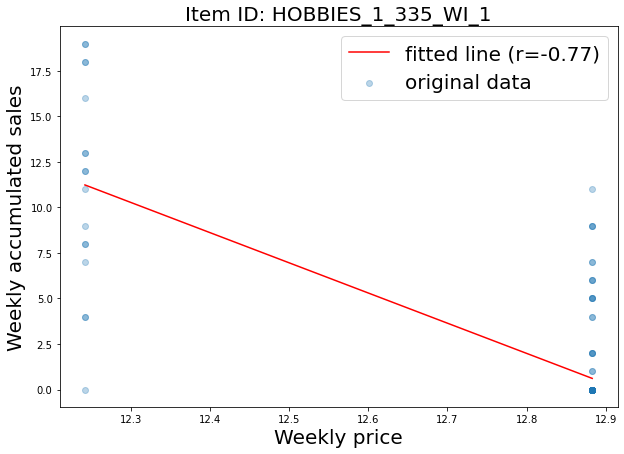

In [73]:
from scipy import stats

# full_id = 'FOODS_1_012_CA_1'
# full_id = 'FOODS_1_098_WI_1'
full_id = 'HOBBIES_1_335_WI_1'
tmp = df_input[df_input['id']==full_id]
x, y = tmp['week_sell_price'], tmp['week_sum_demand']
regs = stats.linregress(x, y)

plt.figure(0, figsize=(10,7))
plt.scatter(x, y, marker='o', label='original data', alpha=0.3)
plt.plot(x, regs[0]*x + regs[1], 'r', label='fitted line (r={:.2f})'.format(regs[2]))
plt.title('Item ID: {}'.format(full_id), fontsize=20)
plt.xlabel('Weekly price', fontsize=20)
plt.ylabel('Weekly accumulated sales', fontsize=20)
plt.legend(fontsize=20)

In [150]:
df_input['wm_yr_wk'].max()

11612

## Model and training
- `wm_yr_wk`: 11130 - 11612 (d_1 - d_1911)
- Data shape
    - \# of dense columns: 12
    - \# of cat columns: 5
- Data split
    - train: `wm_yr_wk` 11130 - 11604
    - valid: `wm_yr_wk` 11605 - 11608
    - test: `wm_yr_wk` 11609 - 11612
    

In [40]:
weekly_filename = 'week_price_demand_corr{-0.6}.csv'

df_input = pd.read_csv(os.path.join(datapath, weekly_filename))
df_input.head()

,id,item_id,dept_id,store_id,cat_id,state_id,wm_yr_wk,week_sell_price,week_sell_price_rel_diff,week_sell_price_roll_sd7,week_sell_price_cumrel,week_lag_t28,week_rolling_mean_t7,week_rolling_mean_t30,week_rolling_mean_t60,week_rolling_mean_t90,week_rolling_mean_t180,week_rolling_std_t7,week_rolling_std_t30,week_sum_demand
0,FOODS_1_012_CA_1,0,0,0,0,0,11133,6.078125,0.0,0.0,0.0,0.0,0.0,0.233276,0.116638,0.077759,0.038879,0.0,0.817383,0.0
1,FOODS_1_012_CA_1,0,0,0,0,0,11134,6.078125,0.0,0.0,0.0,0.0,0.0,0.233276,0.116638,0.077759,0.038879,0.0,0.817383,0.0
2,FOODS_1_012_CA_1,0,0,0,0,0,11135,6.078125,0.0,0.0,0.0,0.0,0.0,0.119019,0.116638,0.077759,0.038879,0.0,0.433838,0.0
3,FOODS_1_012_CA_1,0,0,0,0,0,11136,6.078125,0.0,0.0,0.0,0.0,0.0,0.000000,0.116638,0.077759,0.038879,0.0,0.000000,0.0
4,FOODS_1_012_CA_1,0,0,0,0,0,11137,6.078125,0.0,0.0,0.0,0.0,0.0,0.000000,0.116638,0.077759,0.038879,0.0,0.000000,0.0


In [43]:
print(week_dense_cols)
print(cat_cols)

['week_sell_price', 'week_sell_price_rel_diff', 'week_sell_price_roll_sd7', 'week_sell_price_cumrel', 'week_lag_t28', 'week_rolling_mean_t7', 'week_rolling_mean_t30', 'week_rolling_mean_t60', 'week_rolling_mean_t90', 'week_rolling_mean_t180', 'week_rolling_std_t7', 'week_rolling_std_t30']
['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']


In [44]:
target_scaler = 100.

# Rest is used for training
flag = df_input['wm_yr_wk'] < 11605
X_train = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
y_train = df_input['week_sum_demand'][flag]/target_scaler

# One month of validation data
flag = (df_input['wm_yr_wk'] < 11609) & (df_input['wm_yr_wk'] >= 11605)
X_valid = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
y_valid = df_input['week_sum_demand'][flag]/target_scaler

# Submission data
flag = df_input['wm_yr_wk'] >= 11609
X_test = utils.make_X(df_input[flag], week_dense_cols, cat_cols)
y_test = df_input['week_sum_demand'][flag]/target_scaler

del flag
gc.collect()

# X_train.keys()
# # Resetting ordinal encoder
data_info = {'item_id': 212, 'dept_id': 7, 'store_id': 10, 'cat_id': 3, 'state_id': 3, 'dense1': 12}

# print(data_info)

In [48]:
# X_train
# y_train.plot()

In [295]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, Layer
from tensorflow.keras.models import Model


    
def create_model(data_info, lr=0.001):
#     tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(data_info['dense1'], ), name='dense1')

    # Embedding input
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    item_id_emb = Flatten()(Embedding(data_info['item_id'], 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(data_info['dept_id'], 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(data_info['store_id'], 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(data_info['cat_id'], 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(data_info['state_id'], 1)(state_id_input))

    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, 
                     item_id_emb, dept_id_emb, store_id_emb, cat_id_emb, state_id_emb])
    x = Dense(64, activation="relu")(x)
    x = Dense(10, activation="relu")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, 
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    def my_loss_fn(y_true, y_pred):
        abs_difference = tf.abs(y_true - y_pred)
        return tf.reduce_mean(abs_difference, axis=-1)
        
    model.compile(loss=my_loss_fn,
                  metrics=["mse"],
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

model = create_model(data_info, 0.001)
model.summary()
# keras.utils.plot_model(model, 'model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id (InputLayer)             [(None, 1)]          0                                            
______________________________________________________________________________________________

In [302]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, Layer
from tensorflow.keras.models import Model


class MyActivityRegularizer(Layer):
    """Layer that creates an activity sparsity regularization loss."""

    def __init__(self, rate=1e-2):
        super(MyActivityRegularizer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
        return inputs


class Net(Model):
    
    def __init__(self, data_info, threshold=0.7):
        super(Net, self).__init__()
        self.reg = MyActivityRegularizer()
        
        gc.collect()
        
        # Dense input
#         self.dense_input = Input(shape=(len(dense_cols), ), name='dense1')

        # Embedding input
        self.item_id_layer = Embedding(data_info['item_id'], 3)
        self.dept_id_layer = Embedding(data_info['dept_id'], 1)
        self.store_id_layer = Embedding(data_info['store_id'], 1)
        self.cat_id_layer = Embedding(data_info['cat_id'], 1)
        self.state_id_layer = Embedding(data_info['state_id'], 1)
        
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(10, activation='relu')
        self.dense3 = Dense(1, activation='linear')
        
        self.aux_dense1 = Dense(16, activation='tanh')
        self.aux_dense2 = Dense(1, activation='relu')
        self.aux_relu = keras.layers.ReLU(threshold=threshold)
    
    def call(self, inputs):
        item_id_emb = Flatten()(self.item_id_layer(inputs['item_id']))
        dept_id_emb = Flatten()(self.dept_id_layer(inputs['dept_id']))
        store_id_emb = Flatten()(self.store_id_layer(inputs['store_id']))
        cat_id_emb = Flatten()(self.cat_id_layer(inputs['cat_id']))
        state_id_emb = Flatten()(self.state_id_layer(inputs['state_id']))
    
        # Combine dense and embedding parts and add dense layers. Exit on linear scale.
        x = concatenate([inputs['dense1'], 
                         item_id_emb, dept_id_emb, store_id_emb, cat_id_emb, state_id_emb])
        x = self.dense1(x)
#         self.add_loss(1e-2 * tf.reduce_sum(tf.square(x)))
        x = self.dense2(x)
        outputs = self.dense3(x)    # (batch, 1)
        
        # aux path
        aux_item_id_emb = Flatten()(self.item_id_layer(inputs['item_id']))
        aux_x = self.aux_dense1(concatenate([aux_item_id_emb, inputs['dense1'][:,:1]]))
        aux_x = self.aux_dense2(aux_x)
#         aux_threshold = self.aux_relu(inputs['dense1'][:,1:2])
        aux_x = 0.001*inputs['dense1'][:,1:2]*aux_x    # (batch, 1)
        
        outputs -= aux_x
        
        return outputs

# Set a model
model = Net(data_info, 0.0)

def my_loss_fn(y_true, y_pred):
        abs_difference = tf.abs(y_true - y_pred)
        return tf.reduce_mean(abs_difference, axis=-1)
        
model.compile(loss=my_loss_fn,
              metrics=["mse"],
              optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [303]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, mse = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {:.4f}, mse: {:.4f}\n'.format(loss, mse))

history = model.fit(X_train, 
                    y_train,
                    batch_size=128,
                    epochs=50,
                    shuffle=True,
                    validation_data=(X_valid, y_valid),
                    callbacks=[TestCallback((X_test, y_test))])

Epoch 1/50
504/517 [============================>.] - ETA: 0s - loss: 0.0888 - mse: 0.0467
Testing loss: 0.0827, mse: 0.0351

517/517 [==============================] - 2s 4ms/step - loss: 0.0885 - mse: 0.0463 - val_loss: 0.0789 - val_mse: 0.0379
Epoch 2/50
504/517 [============================>.] - ETA: 0s - loss: 0.0688 - mse: 0.0307
Testing loss: 0.0797, mse: 0.0336

517/517 [==============================] - 2s 4ms/step - loss: 0.0688 - mse: 0.0310 - val_loss: 0.0780 - val_mse: 0.0356
Epoch 3/50
505/517 [============================>.] - ETA: 0s - loss: 0.0658 - mse: 0.0280
Testing loss: 0.0753, mse: 0.0266

517/517 [==============================] - 2s 4ms/step - loss: 0.0657 - mse: 0.0278 - val_loss: 0.0723 - val_mse: 0.0288
Epoch 4/50
504/517 [============================>.] - ETA: 0s - loss: 0.0639 - mse: 0.0261
Testing loss: 0.0775, mse: 0.0334

517/517 [==============================] - 2s 4ms/step - loss: 0.0639 - mse: 0.0260 - val_loss: 0.0754 - val_mse: 0.0343
Epoch 5/50
5

In [ ]:
loss: 0.0563 - mse: 0.0167 - val_loss: 0.0636 - val_mse: 0.0162

In [280]:
sid, eid = 36, 40
small_X_train = {}
for k, v in X_train.items():
    small_X_train[k] = v[sid:eid]
    
model(small_X_train), y_train[sid:eid], model.evaluate(small_X_train, y_train[sid:eid])

1/1 [==============================] - 0s 896us/step - loss: 0.0571 - mse: 0.0571


(<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[-0.01037817],
        [ 0.3201811 ],
        [ 0.45949453],
        [ 0.49490204]], dtype=float32)>,
 36    0.00
 37    0.21
 38    0.10
 39    0.20
 Name: week_sum_demand, dtype: float32,
 [0.05711277946829796, 0.05711277946829796])

In [297]:
val_mse_no_rule = history.history['val_mse']

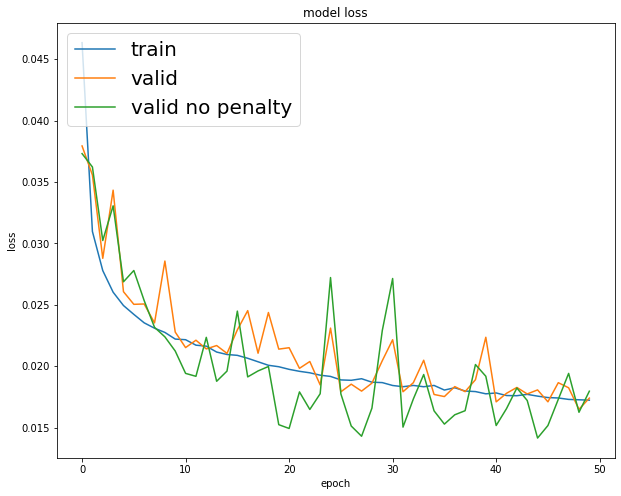

In [304]:
plt.figure(0, figsize=(10,8))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.plot(val_mse_no_rule)
# plt.plot(history.history['val_mse_penalty'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'valid no penalty'], loc='upper left', fontsize=20)
plt.show()

In [301]:
model.evaluate(X_test, y_test)

43/43 [==============================] - 0s 2ms/step - loss: 0.0704 - mse: 0.0184


[0.07042370736598969, 0.018449043855071068]

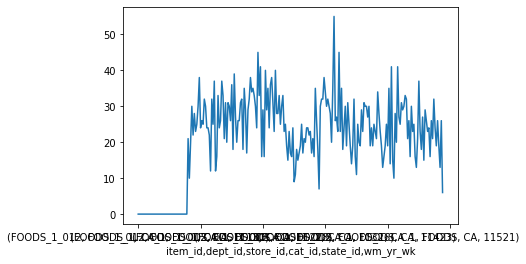

In [271]:
df_price_sales.loc['FOODS_1_012_CA_1']['week_sum_demand'].plot()

In [198]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=128,
                    epochs=30,
                    shuffle=True,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
517/517 [==============================] - 2s 4ms/step - loss: 15.7435 - mse: 1477.4454 - val_loss: 16.9528 - val_mse: 1473.3990
Epoch 2/30
517/517 [==============================] - 2s 3ms/step - loss: 14.8475 - mse: 1424.6191 - val_loss: 16.3777 - val_mse: 1441.4720
Epoch 3/30
517/517 [==============================] - 2s 3ms/step - loss: 14.4065 - mse: 1395.9468 - val_loss: 15.8944 - val_mse: 1412.4229
Epoch 4/30
517/517 [==============================] - 2s 3ms/step - loss: 14.0168 - mse: 1368.9315 - val_loss: 15.4721 - val_mse: 1384.9357
Epoch 5/30
517/517 [==============================] - 2s 3ms/step - loss: 13.6639 - mse: 1343.1012 - val_loss: 15.0854 - val_mse: 1359.1366
Epoch 6/30
517/517 [==============================] - 2s 3ms/step - loss: 13.3413 - mse: 1318.7836 - val_loss: 14.7366 - val_mse: 1334.9562
Epoch 7/30
517/517 [==============================] - 2s 3ms/step - loss: 13.0472 - mse: 1295.7687 - val_loss: 14.4198 - val_mse: 1312.2816
Epoch 8/30
517/517 [

In [195]:
X_valid['dense1'].shape

(1368, 12)

In [197]:
1368/342

4.0